(Autoencoders)=
# Autoencoders and anomaly detection

This section explores the potential usage of autoencoders in the context of credit card fraud detection.

## Definition and usage

An autoencoder is a special type of deep learning architecture used to learn representations of data based solely on descriptive features. The representation, which is a transformation of the raw data, is learned with the objective to reconstruct the original data the most accurately. This representation learning strategy can be used for dimensionality reduction, denoising, or even generative applications.

An autoencoder can be divided into two parts:
* The **encoder part** that maps the input into the representation, also referred to as the "code" or the "bottleneck".
* The **decoder that** maps the code to a reconstruction of the input.

![Autoencoder](https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook/blob/main/Chapter_7_DeepLearning/images/autoencoder.png?raw=1)

The encoder and decoder can have complex architectures like recurrent neural networks when dealing with sequential data or convolutional neural networks when dealing with images. But in their simplest form, they are multi-layer feed-forward neural networks. The dimension of the code, which is also the input of the decoder, can be fixed arbitrarily. This dimension is generally chosen to be lower than the original input dimension to reduce the dimensionality and to learn underlying meta variables. The dimension of the output of the decoder is the same as the input of the encoder because its purpose is to reconstruct the input.  

The architecture is generally trained end-to-end by optimizing the input reconstruction, i.e. by minimizing a loss that measures a difference between the model's output and the input. It can be trained with any unlabeled data. Note that when the autoencoder is "deep", i.e. there are intermediate layers $h_2$ and $h_2'$ respectively between the input $x$ and the bottleneck $h$ and between the bottleneck and the output $y$ (like in the figure above), one can train the layers successively instead of simultaneously. More precisely, one can first consider a submodel with only $x$, $h_2$ and $y$ and train it to reconstruct the input from the intermediate code $h_2$. Then, consider a second submodel with only $h_2$, $h$ and $h_2'$ and train it to reconstruct the intermediate code from the code $h$. Finally, fine-tune the whole model with $x$, $h_2$, $h$, $h_2'$ and $y$ to reconstruct the input.

Autoencoders can be used as techniques for unsupervised or semi-supervised anomaly detection, which led them to be used multiple times for credit card fraud detection {cite}`an2015variational,zhou2017anomaly`.


### Anomaly detection

Although not detailed before, fraud detection can be performed with both supervised and unsupervised techniques {cite}`carcillo2019combining,veeramachaneni2016ai`, as it is a special instance of a broader problem referred to as anomaly detection or outlier detection. The latter generally includes techniques to identify items that are rare or differ significantly from the "normal" behavior, observable in the majority of the data.

And one can easily see how a credit card fraud can be defined as an anomaly in transactions. These anomalies can be rare events or unexpected bursts in the activity of a single cardholder behavior, or specific patterns, not necessarily rare, in the global consumers' behavior. Rare events or outliers can be detected with unsupervised techniques that learn the normality and which are able to estimate discrepancy to this normality. But detection of other types of anomaly can require supervised techniques with proper training.

Therefore, one can think of three types of anomaly detection techniques:

* Supervised techniques that were widely explored in previous sections and chapters. These techniques require annotations on data that consist of two classes, "normal" (or "genuine") and "abnormal" (or "fraud"), and they learn to discriminate between those classes.
* Unsupervised techniques that aim at detecting anomalies by modeling the majority behavior and considering it as "normal". Then they detect the "abnormal" or fraudulent behavior by searching for examples that do not fit well to the normal behavior.  
* Semi-supervised techniques that are in between the two above cases and that can learn from both unlabeled and labeled data to detect fraudulent transactions.

An autoencoder can be used to model the normal behavior of data and detect outliers using the reconstruction error as an indicator. In particular, one way to do so is to train it to globally reconstruct transactions in a dataset. The normal trend that is observed in the majority of transactions will be better approximated than rare events. Therefore, the reconstruction error of "normal" data will be lower than the reconstruction error of outliers.

An autoencoder can therefore be considered as an unsupervised technique for fraud detection. In this section, we will implement and test it for both semi-supervised and unsupervised fraud detection.

### Representation learning

Other than unsupervised anomaly detection, an autoencoder can simply be used as a general representation learning method for credit card transaction data. In a more complex manner than PCA, an autoencoder will learn a transformation from the original feature space to a representation space with new variables that encodes all the useful information to reconstruct the original data.

If the dimension of the code is chosen to be 2 or 3, one can visualize the transaction in the novel 2D/3D space. Otherwise, the code can also be used for other purposes, like:

* Clustering: Clustering can be performed on the code instead of the original features. Groups learned from the clustering can be useful to characterize the types of behaviors of consumers or fraudsters.
* Additional or replacement variables: The code can be used as replacement variables, or additional variables, to train any supervised learning model for credit card fraud detection.

### Content of the section

The following puts into practice the use of autoencoders for credit card fraud detection. It starts by defining the data structures for unlabeled transactions. It then implements and evaluates an autoencoder for unsupervised fraud detection. The autoencoder is then used to compute transaction representation for visualization and clustering. Finally, we explore a semi-supervised strategy for fraud detection.

Let us dive into it by making all necessary imports.

In [1]:
import os

In [3]:
# Initialization: Load shared functions and simulated data

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   967k      0 --:--:-- --:--:-- --:--:--  980k


This section reuses some "deep learning" specific material that was implemented in the previous section. It includes the evaluation function, the preparation of generators, the early-stopping strategy, the training loop, and so on. This material has been added to the `shared functions`.

## Data loading

The same experimental setup as the previous section is used for our exploration, i.e. a fixed training and validation period, and the same features from the transformed simulated data (`simulated-data-transformed/data/`).

In [4]:
DIR_INPUT='simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: user 417 ms, sys: 2.59 s, total: 3.01 s
Wall time: 3.15 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [5]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

## Autoencoder implementation

For the sake of consistency, the implementation of the autoencoders will be done with the `PyTorch` library. As usual, a seed will be used as follows to ensure reproducibility:

In [6]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

Selected device is cpu


Let us also convert our features and labels into torch tensors.

In [7]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

The autoencoder has the same input as the baseline feed-forward neural network but a different output. Instead of the fraud/genuine label, its target will be the same as the input. Therefore, the experiments here will not rely on the `FraudDataset` defined before but on a new Dataset: `FraudDatasetUnsupervised`, which only receives the descriptive features of the transaction `x` and returns it as both input and output.

In [8]:
class FraudDatasetUnsupervised(torch.utils.data.Dataset):

    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [9]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

This Dataset can also be turned into `DataLoaders` with the function `prepare_generators` from the shared functions.

In [10]:
training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

The second and main element in our deep learning pipeline is the model/module. Since our data are tabular and each sample is a vector, we will resort to a regular feed-forward autoencoder. Its definition is very similar to our supervised feed-forward network for fraud detection, except that the output has as many neurons as the input, with linear activations, instead of a single neuron with sigmoid activation. An intermediate layer, before the representation layer, will also be considered such that the overall succession of layers with their dimensions (`input_dim`, `output_dim`) are the following:

* A first input layer with ReLu activation (`input_size`, `intermediate_size`)
* A second layer with ReLu activation (`intermediate_size`, `code_size`)
* A third layer with ReLu activation (`code_size`, `intermediate_size`)
* An output layer with linear activation (`intermediate_size`, `input_size`)

In [11]:
class SimpleAutoencoder(torch.nn.Module):

        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size
            self.code_size  = code_size

            self.relu = torch.nn.ReLU()

            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)

            #decoder
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)


        def forward(self, x):

            hidden = self.fc1(x)
            hidden = self.relu(hidden)

            code = self.fc2(hidden)
            code = self.relu(code)

            hidden = self.fc3(code)
            hidden = self.relu(hidden)

            output = self.fc4(hidden)
            #linear activation in final layer)

            return output

The third element of our pipeline is the optimization problem. The underlying machine learning problem is a regression here, where the predicted and expected outputs are real-valued variables. Therefore, the most adapted loss function is the mean squared error `torch.nn.MSELoss`.

In [12]:
criterion = torch.nn.MSELoss().to(DEVICE)

## Using the autoencoder for unsupervised fraud detection

As explained in the introduction, the autoencoder's goal is to predict the input from the input. Therefore, one cannot directly use its prediction for fraud detection. Instead, the idea is to use its reconstruction error, i.e. the mean squared error (MSE) between the input and the output, as an indicator for fraud likelihood. The higher the error, the higher the risk score. Therefore, the reconstruction error can be considered as a predicted fraud risk score, and its relevance can be directly measured with any threshold-free metric.

For that purpose, let us define a function `per_sample_mse` that will compute the MSE of a `model` for each sample provided by a `generator`:

In [13]:
def per_sample_mse(model, generator):

    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []

    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)

    return batch_losses

Here is what happens when trying it on the validation samples with an untrained autoencoder. Let us use 100 neurons in the intermediate layer and 20 neurons in the representation layer:

In [14]:
seed_everything(SEED)
model = SimpleAutoencoder(x_train.shape[1], 100, 20).to(DEVICE)
losses = per_sample_mse(model, valid_generator)

Before training it, here are the loss values for the first five samples, and the overall average loss.

In [15]:
print(losses[0:5])
print(np.mean(losses))

[0.6754841, 0.79146266, 1.1697072, 0.8070149, 1.258897]
0.9325165


With random weights in its layers, the untrained autoencoder is rather bad at reconstruction. It has a squared error of 0.93 on average for the standardized transaction variables.

Let us now train it and see how this evolves. Like in the previous section, the process is the following:
* Prepare the generators.
* Define the criterion.
* Instantiate the model.
* Perform several optimization loops (with an optimization technique like gradient descent with Adam) on the training data.
* Stop optimization with early stopping using validation data.

All of these steps are implemented in the shared function `training_loop` defined in the previous section.

In [16]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [17]:
model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=500,
                                                                        verbose=True)


Epoch 0: train loss: 0.4457241598495334
valid loss: 0.1178910775303515
New best score: 0.1178910775303515

Epoch 1: train loss: 0.08445224239638727
valid loss: 0.04473797863990557
New best score: 0.04473797863990557

Epoch 2: train loss: 0.038134463823241954
valid loss: 0.028129168459382212
New best score: 0.028129168459382212

Epoch 3: train loss: 0.023945421552068302
valid loss: 0.01683971156249118
New best score: 0.01683971156249118

Epoch 4: train loss: 0.013856794773716744
valid loss: 0.009604571911867688
New best score: 0.009604571911867688

Epoch 5: train loss: 0.007683092729147545
valid loss: 0.005340766875694195
New best score: 0.005340766875694195

Epoch 6: train loss: 0.005278766202654896
valid loss: 0.004115461511791893
New best score: 0.004115461511791893

Epoch 7: train loss: 0.004053213871101961
valid loss: 0.0031357047751118415
New best score: 0.0031357047751118415

Epoch 8: train loss: 0.0030779097410431754
valid loss: 0.0025029468850125787
New best score: 0.002502946

In [18]:
losses = per_sample_mse(model, valid_generator)
print(losses[0:5])
print(np.mean(losses))

[3.3718406e-05, 2.8931066e-05, 3.708091e-05, 4.61444e-05, 3.6596917e-05]
7.050447e-05


In [19]:
print(x_train[0])
print(model(x_train[0].to(DEVICE)))

tensor([-0.1323, -0.6306,  2.1808, -0.3003,  0.1241, -1.6917,  0.5035, -1.6630,
        -0.0482, -0.9810, -0.0816, -1.9895, -0.1231, -0.9719, -0.1436])
tensor([-0.1361, -0.6270,  2.1803, -0.2967,  0.1200, -1.6988,  0.5018, -1.6773,
        -0.0494, -0.9763, -0.0751, -1.9800, -0.1182, -0.9696, -0.1373],
       grad_fn=<ViewBackward0>)


When trained, the autoencoder is much better at encoding/decoding a transaction. It now obtains a very low squared error (0.00008) on average for our standardized transaction variables. Moreover, the example above (with `x_train[0]`) illustrates how well the reconstructed transaction is similar to the input transaction.

Now the remaining question is the following: are frauds less well reconstructed than genuine transactions such that reconstruction error can be used as an indicator of fraud risk?

To answer, one can compute the average squared error for fraudulent and genuine transactions separately.

In [20]:
genuine_losses = np.array(losses)[y_valid.cpu().numpy() == 0]
fraud_losses = np.array(losses)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.001359552
Average genuine reconstruction error: 6.2211075e-05


It appears that frauds are indeed less well reconstructed than genuine transactions, which is very encouraging. Let us now compute the AUC ROC, the average precision, and card precision@100 on the validation set by considering the reconstruction error as a predicted fraud score.

In [21]:
predictions_df=valid_df
predictions_df['predictions']=losses

performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.84,0.162,0.2


Although less accurate than the supervised techniques covered before, this unsupervised method leads to encouraging results and is much more accurate than the random classifier.

## Comparison with another unsupervised baseline: Isolation Forest

The autoencoder has a very high AUC ROC without making any use of the labels during training. To contrast this result and as a sanity check, it is interesting to implement and test another popular unsupervised baseline.

Isolation Forest is a state-of-the-art anomaly detection technique that relies on tree-based models. It computes, for each sample of data, an anomaly score that reflects how atypical the sample is. In order to calculate this score, the algorithm tries to isolate the sample from the rest of the dataset recursively: it chooses a random cutoff (pair feature-threshold), and evaluates if it allows the sample at hand to be isolated. If so, the algorithm stops. Otherwise, it adds another cutoff, and repeats the process until the sample is isolated from the rest. This recursive data partitioning can be represented as a decision tree and the number of cutoffs necessary to isolate a sample can be considered as the anomaly score. The lower the number of cutoffs (i.e. the easier it is to isolate the data point), the more likely the sample is to be an outlier.

This algorithm is implemented in `sklearn` under the class `sklearn.ensemble.IsolationForest`. Let us train it on the training data and evaluate the anomaly score of the validation data. On the latter, the anomaly score of a sample is computed from the average depth of the leaves reached by it.

In [22]:
from sklearn.ensemble import IsolationForest

anomalyclassifier = IsolationForest(random_state=SEED, n_estimators=10)
anomalyclassifier.fit(train_df[input_features])

IsolationForest(n_estimators=10, random_state=42)

In [23]:
predictions_df = valid_df
predictions_df['predictions'] = -anomalyclassifier.score_samples(valid_df[input_features])

performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.808,0.164,0.19


We can see that this state-of-the-art unsupervised baseline provides performances that are close (slightly lower) to those of the autoencoder.

## Transactions representation, visualization and clustering

Additionally to its ability to detect anomalies, the autoencoder has other advantages, as was mentioned in the introduction. In particular, after training, one can use the encoder part alone to obtain representations of the transactions for visualization or clustering purposes. For that, let us train an autoencoder with a code dimension of 2.

In [24]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
small_model = SimpleAutoencoder(len(input_features), 100,2).to(DEVICE)
optimizer = torch.optim.Adam(small_model.parameters(), lr = 0.0001)

small_model,training_execution_time,train_losses,valid_losses = training_loop(small_model,
                                                                              training_generator,
                                                                              valid_generator,
                                                                              optimizer,
                                                                              criterion,
                                                                              max_epochs=500,
                                                                              verbose=True)



Epoch 0: train loss: 0.7699022939282667
valid loss: 0.5805507265153479
New best score: 0.5805507265153479

Epoch 1: train loss: 0.5995249318860001
valid loss: 0.5214713392361917
New best score: 0.5214713392361917

Epoch 2: train loss: 0.5190003691793172
valid loss: 0.47640629316288263
New best score: 0.47640629316288263

Epoch 3: train loss: 0.49128978233606363
valid loss: 0.46462850108172726
New best score: 0.46462850108172726

Epoch 4: train loss: 0.48287230314077884
valid loss: 0.4596672722224981
New best score: 0.4596672722224981

Epoch 5: train loss: 0.477416105183771
valid loss: 0.4549809480951132
New best score: 0.4549809480951132

Epoch 6: train loss: 0.47170347211807684
valid loss: 0.4498166563243814
New best score: 0.4498166563243814

Epoch 7: train loss: 0.4637151646568488
valid loss: 0.4434466640480229
New best score: 0.4434466640480229

Epoch 8: train loss: 0.45432143862115265
valid loss: 0.436360311866458
New best score: 0.436360311866458

Epoch 9: train loss: 0.44618122

Once trained, to obtain the transactions 2D-representation from the encoder part alone, the idea is to simply apply the first two layers of the Autoencoder.

In [25]:
def compute_representation(x,model):
    x_representation = model.fc1(x)
    x_representation = model.relu(x_representation)
    x_representation = model.fc2(x_representation)
    x_representation = model.relu(x_representation)
    return x_representation

In [26]:
x_train_representation = []
for x_batch, y_batch in training_generator:
    x_train_representation.append(compute_representation(x_batch, small_model).detach().cpu().numpy())

In [27]:
x_train_representation = np.vstack(x_train_representation)

After this process, the obtained representations of the training data are in 2D:

In [28]:
print(x_train.shape)
print(x_train_representation.shape)

torch.Size([66928, 15])
(66928, 2)


Transactions can be now visualized on a plane (e.g. with different colors for frauds and genuine)

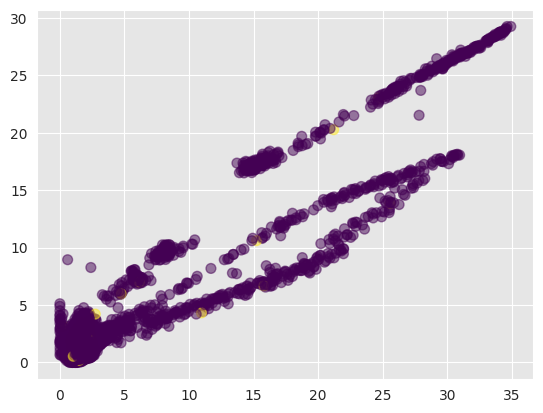

In [38]:
plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_train.numpy(), s=50, cmap='viridis', alpha=0.5)

It is also possible to apply a K-means clustering and vizualize the clusters:

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=SEED)
kmeans.fit(x_train_representation)
y_kmeans = kmeans.predict(x_train_representation)

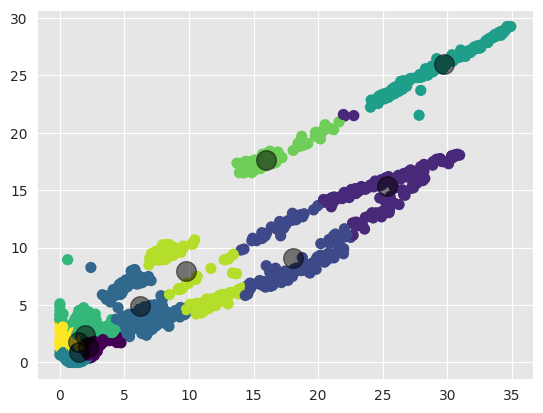

In [31]:
plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Semi-supervised fraud detection

Finally, the autoencoder can be used in a semi-supervised credit card fraud detection system {cite}`carcillo2019combining`. There are two main ways to do this:
* `W1`: The most natural one is to keep the autoencoder as is and train it on all available labeled and unlabeled data. Then, to combine it with a supervised neural network trained only on labeled data. The combination can be done by aggregating the predicted score from the supervised model and the predicted score from the unsupervised model (`W1A`), or more elegantly by providing the unsupervised risk score from the autoencoder (reconstruction error) as an additional variable to the supervised model (`W1B`) as in {cite}`alazizi2020dual`.
* `W2`: Another possibility is to change the architecture of the autoencoder into a hybrid semi-supervised model. More precisely, one can add, to the autoencoder, output neurons similar to those of the supervised neural network from the previous section, and additionally predict them from the code neurons. Therefore, the learned representation (code neurons) will be shared between the decoder network that aims at reconstructing the input and the prediction network that aims at predicting fraud. The first is trained on all samples and the latter is only trained on labeled samples. The intuition with this approach is similar to pre-training in natural language processing: learning a representation that embeds the underlying structure in the input data can help with solving supervised tasks.

The following explores the `W1B` semi-supervised approach. But first, let us reevaluate here the baseline supervised model without the reconstruction error feature. `FraudDataset` and `SimpleFraudMLPWithDropout` are available in the shared functions and can be directly used here.

In [32]:
seed_everything(SEED)

training_set_supervised = FraudDataset(x_train.to(DEVICE), y_train.to(DEVICE))
valid_set_supervised = FraudDataset(x_valid.to(DEVICE), y_valid.to(DEVICE))

training_generator_supervised,valid_generator_supervised = prepare_generators(training_set_supervised,
                                                                              valid_set_supervised,
                                                                              batch_size=64)

model_supervised = SimpleFraudMLPWithDropout(len(input_features), 1000, 0.2).to(DEVICE)
optimizer = torch.optim.Adam(model_supervised.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss().to(DEVICE)

model_supervised,training_execution_time,train_losses_dropout,valid_losses_dropout =\
    training_loop(model_supervised,
                  training_generator_supervised,
                  valid_generator_supervised,
                  optimizer,
                  criterion,
                  verbose=True)


Epoch 0: train loss: 0.10150729733595827
valid loss: 0.03586987113793854
New best score: 0.03586987113793854

Epoch 1: train loss: 0.03902060148906297
valid loss: 0.026458203324366138
New best score: 0.026458203324366138

Epoch 2: train loss: 0.03105295945206447
valid loss: 0.023758493652923512
New best score: 0.023758493652923512

Epoch 3: train loss: 0.028847194628889742
valid loss: 0.0231802007888286
New best score: 0.0231802007888286

Epoch 4: train loss: 0.027697844432584984
valid loss: 0.022382891958559064
New best score: 0.022382891958559064

Epoch 5: train loss: 0.026617259042912712
valid loss: 0.021873263562545996
New best score: 0.021873263562545996

Epoch 6: train loss: 0.026207293777096213
valid loss: 0.02156185812973341
New best score: 0.02156185812973341

Epoch 7: train loss: 0.025602950999890784
valid loss: 0.021646343356843203
1  iterations since best score.

Epoch 8: train loss: 0.025374168047083125
valid loss: 0.020708034721666265
New best score: 0.020708034721666265

In [33]:
predictions = []

for x_batch, y_batch in valid_generator_supervised:
    predictions.append(model_supervised(x_batch.to(DEVICE)).detach().cpu().numpy())

predictions_df=valid_df
predictions_df['predictions']=np.vstack(predictions)

performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.858,0.638,0.277


Now, for the `W1B` semi-supervised approach, let us compute the reconstruction error of all transactions with our first autoencoder (stored in `model`) and add it as a new variable in `train_df` and `valid_df`.

In [34]:
loader_params = {'batch_size': 64,
                 'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_set, **loader_params)
valid_generator = torch.utils.data.DataLoader(valid_set, **loader_params)

train_reconstruction = per_sample_mse(model, training_generator)
valid_reconstruction = per_sample_mse(model, valid_generator)

train_df["reconstruction_error"] = train_reconstruction
valid_df["reconstruction_error"] = valid_reconstruction

Then, we can reevaluate the supervised model with this extra variable.

In [35]:
seed_everything(SEED)

input_features_new = input_features + ["reconstruction_error"]

# Rescale the reconstruction error
(train_df, valid_df)=scaleData(train_df, valid_df, ["reconstruction_error"])

x_train_new = torch.FloatTensor(train_df[input_features_new].values)
x_valid_new = torch.FloatTensor(valid_df[input_features_new].values)

training_set_supervised_new = FraudDataset(x_train_new.to(DEVICE), y_train.to(DEVICE))
valid_set_supervised_new = FraudDataset(x_valid_new.to(DEVICE), y_valid.to(DEVICE))

training_generator_supervised,valid_generator_supervised = prepare_generators(training_set_supervised_new,
                                                                              valid_set_supervised_new,
                                                                              batch_size=64)

model_supervised = SimpleFraudMLPWithDropout(len(input_features_new), 100, 0.2).to(DEVICE)
optimizer = torch.optim.Adam(model_supervised.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss().to(DEVICE)

model_supervised,training_execution_time,train_losses_dropout,valid_losses_dropout = \
    training_loop(model_supervised,
                  training_generator_supervised,
                  valid_generator_supervised,
                  optimizer,
                  criterion,
                  verbose=True)

predictions = []
for x_batch, y_batch in valid_generator_supervised:
    predictions.append(model_supervised(x_batch).detach().cpu().numpy())


Epoch 0: train loss: 0.3254070365320656
valid loss: 0.11778437176851626
New best score: 0.11778437176851626

Epoch 1: train loss: 0.08699042184979977
valid loss: 0.0506878088528667
New best score: 0.0506878088528667

Epoch 2: train loss: 0.055142381573968474
valid loss: 0.037270716380307586
New best score: 0.037270716380307586

Epoch 3: train loss: 0.045299982571935224
valid loss: 0.03202125202620127
New best score: 0.03202125202620127

Epoch 4: train loss: 0.04046391387181588
valid loss: 0.028893071472074816
New best score: 0.028893071472074816

Epoch 5: train loss: 0.03604612481801719
valid loss: 0.02685588078568257
New best score: 0.02685588078568257

Epoch 6: train loss: 0.03346871140472641
valid loss: 0.025364907976504557
New best score: 0.025364907976504557

Epoch 7: train loss: 0.03160627614697851
valid loss: 0.024563861195547657
New best score: 0.024563861195547657

Epoch 8: train loss: 0.031046122107984245
valid loss: 0.02386654261703211
New best score: 0.02386654261703211

E

In [36]:
predictions_df=valid_df
predictions_df['predictions']=np.vstack(predictions)

performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.862,0.651,0.276


The three metrics are very close, with or without the additional feature. They respectively went from 0.859, 0.646 and 0.28 to 0.861, 0.651 and 0.276. The conclusion is therefore mitigated and does not show a significant benefit from this semi-supervised modeling. Nevertheless, keep in mind that, in practice in a different setting, there can be a benefit, especially if the quantity of available unlabeled data is much larger than the quantity of labeled data.

Also, note that there are several directions for improvement. For example, this semi-supervised technique can be pushed further by training two separate autoencoders, for each class, and by using both reconstruction errors as additional variables.

## Conclusion

Autoencoders are part of the large deep learning models family. Their goal is to learn representations to reconstruct descriptive variables, so they have been widely used for unsupervised learning problems. Anomaly detection, and in particular fraud detection, can be tackled with unsupervised or semi-supervised techniques.

In this section, we used the autoencoder, and in particular its reconstruction error, as an indicator for fraud risk. Used solely (unsupervised method), it detects data points that are away from the rest of the distribution, which allows detecting many frauds but also introduces a lot of false alerts (e.g. genuine transactions that have rare characteristics). Therefore, it obtains a decent AUC ROC but low precision-based metrics. Used as an extra variable in a supervised method (semi-supervised usage), it can allow boosting the performance in specific settings.